Author: Zidong Chen<br />
Date: 2024/6/22<br />
Description: This is a simple implementation of non_positive_definite_fixer.<br />
Note: When encountering a non-positive definite matrix during optimization, the easiest and fastest way to fix it is to set default dtype to double or reduce the learning rate.

In [1]:
import torch
from core.non_positive_definite_fixer import remove_similar_data, Gaussian_log_likelihood, train_adam_with_reset
from core.kernel import ARDKernel
from matplotlib import pyplot as plt
import core.GP_CommonCalculation as GP
import torch.nn as nn
import numpy as np

JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

xtr.size: torch.Size([100, 1]) ytr.size: torch.Size([100, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


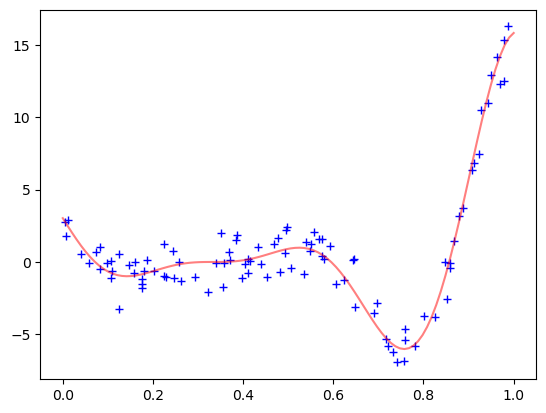

In [2]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha=0.5)
plt.show()

In [ ]:
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        self.kernel = ARDKernel(1)
        self.data = GP.XYdata_normalization(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)
        self.X, self.Y = remove_similar_data(self.X,
                                             self.Y)  # implement on remove_similar_data in non_positive_definite_fixer

        # noise variance
        self.log_beta = nn.Parameter(torch.ones(1) * 0)

    def forward(self, Xte):
        Xte = self.data.normalize(Xte)
        sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
            self.X.size(0))
        K_xt = self.kernel(self.X, Xte)
        K_tt = self.kernel(Xte, Xte)

        mean, var = GP.conditional_Gaussian(self.Y, sigma, K_xt, K_tt)
        var_diag = var.diag().view(-1, 1)
        # de-normalized
        mean, var_diag = self.data.denormalize_y(mean, var_diag)
        return mean, var_diag

    def negative_lower_bound(self):
        K_xx = self.kernel(self.X, self.X) + JITTER * torch.eye(self.X.size(0))
        return -Gaussian_log_likelihood(self.Y, K_xx,
                                        Kinv_method='eigen')  # implement on eigendecomposition in non_positive_definite_fixer#%% md
Author: Zidong Chen<br />
Date: 2024/6/22<br />
Description: This is a simple implementation of non_positive_definite_fixer.<br />
Note: When encountering a non-positive definite matrix during optimization, the easiest and fastest way to fix it is to set default dtype to double or reduce the learning rate.

In [ ]:
import torch
from core.non_positive_definite_fixer import remove_similar_data, Gaussian_log_likelihood, train_adam_with_reset
from core.kernel import ARDKernel
from matplotlib import pyplot as plt
import core.GP_CommonCalculation as GP
import torch.nn as nn
import numpy as np

JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

In [ ]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha=0.5)
plt.show()

In [ ]:
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        self.kernel = ARDKernel(1)
        self.data = GP.XYdata_normalization(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)
        self.X, self.Y = remove_similar_data(self.X,
                                             self.Y)  # implement on remove_similar_data in non_positive_definite_fixer

        # noise variance
        self.log_beta = nn.Parameter(torch.ones(1) * 0)

    def forward(self, Xte):
        Xte = self.data.normalize(Xte)
        sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
            self.X.size(0))
        K_xt = self.kernel(self.X, Xte)
        K_tt = self.kernel(Xte, Xte)

        mean, var = GP.conditional_Gaussian(self.Y, sigma, K_xt, K_tt)
        var_diag = var.diag().view(-1, 1)
        # de-normalized
        mean, var_diag = self.data.denormalize_y(mean, var_diag)
        return mean, var_diag

    def negative_lower_bound(self):
        K_xx = self.kernel(self.X, self.X) + JITTER * torch.eye(self.X.size(0))
        return -Gaussian_log_likelihood(self.Y, K_xx,
                                        Kinv_method='eigen')  # implement on eigendecomposition in non_positive_definite_fixer


In [ ]:
model=cigp(xtr,ytr)
# implement on parameter_reset in non_positive_definite_fixer
train_adam_with_reset(model, niteration=40)

In [ ]:
with torch.no_grad():
    ypred, yvar = model.forward(xte)
print(yvar.size())
plt.fill_between(xte.squeeze().numpy(), ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2, label='95% Confidence interval')
plt.plot(xte.numpy(), ypred.numpy(), 'r-', alpha = 0.5, label='Predictive mean')
plt.plot(xtr.numpy(), ytr.numpy(), 'b+', label='Training data')
plt.legend()
plt.show()

In [7]:
model=cigp(xtr,ytr)
# implement on parameter_reset in non_positive_definite_fixer
train_adam_with_reset(model, niteration=40)

Iteration 10: Loss: 1495.04826
Iteration 20: Loss: 608.33623
Iteration 30: Loss: 254.79862
Iteration 40: Loss: 147.69792


torch.Size([100, 1])


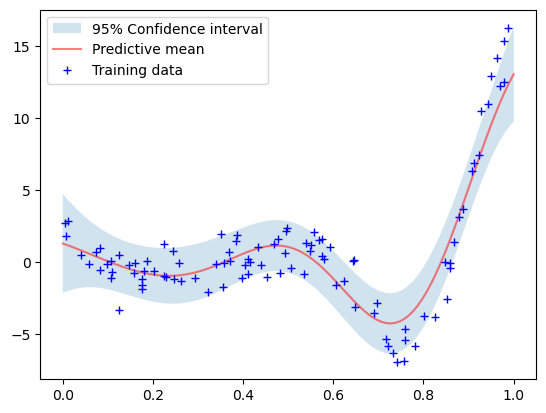

In [10]:
with torch.no_grad():
    ypred, yvar = model.forward(xte)
print(yvar.size())   
plt.fill_between(xte.squeeze().numpy(), ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2, label='95% Confidence interval')
plt.plot(xte.numpy(), ypred.numpy(), 'r-', alpha = 0.5, label='Predictive mean')
plt.plot(xtr.numpy(), ytr.numpy(), 'b+', label='Training data')
plt.legend()
plt.show()